# **Install & Import Required Libraries**

In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

from skimage.feature import hog
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

# **Load Dataset**

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
DATASET_PATH = "/content/drive/MyDrive/flower"
os.listdir(DATASET_PATH)

['Sunflower', 'Rose', 'Hibiscus']

In [5]:
# Image size to which all images will be resized
IMG_SIZE = 128

# Lists to store image data and corresponding class labels
images = []
labels = []

# Get sorted list of class (folder) names from dataset directory
class_names = sorted(os.listdir(DATASET_PATH))

# Loop through each class folder
for label, class_name in enumerate(class_names):

    # Path to the current class directory
    class_path = os.path.join(DATASET_PATH, class_name)

    # Loop through each image in the class directory
    for img_name in os.listdir(class_path):

        # Skip files that are not images
        if not img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
            continue

        # Full path to the image
        img_path = os.path.join(class_path, img_name)

        # Read the image using OpenCV
        img = cv2.imread(img_path)

        # Skip unreadable or corrupted images
        if img is None:
            print("Skipped unreadable image:", img_path)
            continue

        # Resize image to fixed size for uniform input
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))

        # Append image data and corresponding label
        images.append(img)
        labels.append(label)

# Convert lists to NumPy arrays for efficient processing
images = np.array(images)
labels = np.array(labels)


# **Dataset Evaluation**

In [6]:
# Count images per class
class_counts = [np.sum(labels == i) for i in range(len(class_names))]
total_images = sum(class_counts)
class_percentages = [count / total_images * 100 for count in class_counts]

# --- Print dataset summary ---
print("Dataset Summary:\n")
print(f"{'Class':15} {'Count':>8} {'Percentage':>12}")
print("-"*37)
for name, count, perc in zip(class_names, class_counts, class_percentages):
    print(f"{name:15} {count:8} {perc:11.2f}%")
print("-"*37)
print(f"{'Total':15} {total_images:8} {100:11.2f}%")

Dataset Summary:

Class              Count   Percentage
-------------------------------------
Hibiscus             212       45.30%
Rose                 109       23.29%
Sunflower            147       31.41%
-------------------------------------
Total                468      100.00%


/tmp/ipython-input-1793385732.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_names, y=class_counts, palette="pastel")


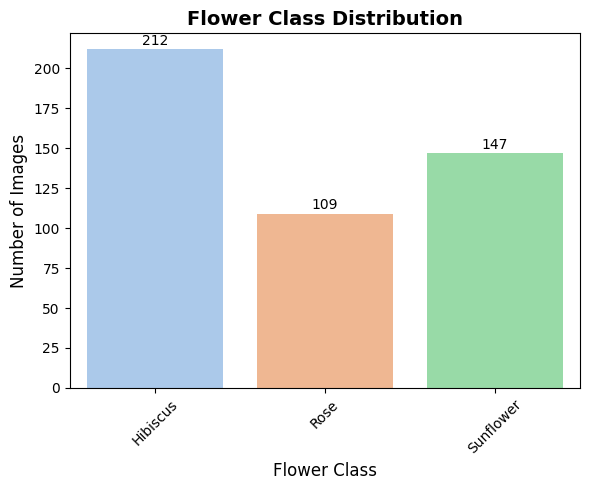

In [7]:
import seaborn as sns

# Count images per class
class_counts = [np.sum(labels == i) for i in range(len(class_names))]

# Plot
plt.figure(figsize=(6,5))
sns.barplot(x=class_names, y=class_counts, palette="pastel")
plt.title("Flower Class Distribution", fontsize=14, weight="bold")
plt.ylabel("Number of Images", fontsize=12)
plt.xlabel("Flower Class", fontsize=12)
plt.xticks(rotation=45)
plt.ylim(0, max(class_counts) + 10)

# Add value labels on top of bars
for i, count in enumerate(class_counts):
    plt.text(i, count + 1, str(count), ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()


# **Feature Extraction**

## **HOG Features**

In [8]:
# Lists to store HOG feature vectors and HOG visualization images
hog_features = []
hog_images = []

# Loop through each image in the dataset
for img in images:

    # Convert RGB/BGR image to grayscale (HOG works on intensity gradients)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Extract HOG features and corresponding visualization image
    features, hog_image = hog(
        gray,
        orientations=9,              # Number of gradient orientation bins
        pixels_per_cell=(8, 8),       # Size of each cell
        cells_per_block=(2, 2),       # Number of cells in each block
        block_norm='L2-Hys',          # Block normalization method
        visualize=True               # Return HOG visualization image
    )

    # Store extracted feature vector
    hog_features.append(features)

    # Store HOG visualization image
    hog_images.append(hog_image)

# Convert lists to NumPy arrays for efficient computation
hog_features = np.array(hog_features)
hog_images = np.array(hog_images)

# Print shapes to verify extraction
print("HOG features shape:", hog_features.shape)
print("HOG images shape:", hog_images.shape)


HOG features shape: (468, 8100)
HOG images shape: (468, 128, 128)


### **HOG Feature Visulaization**


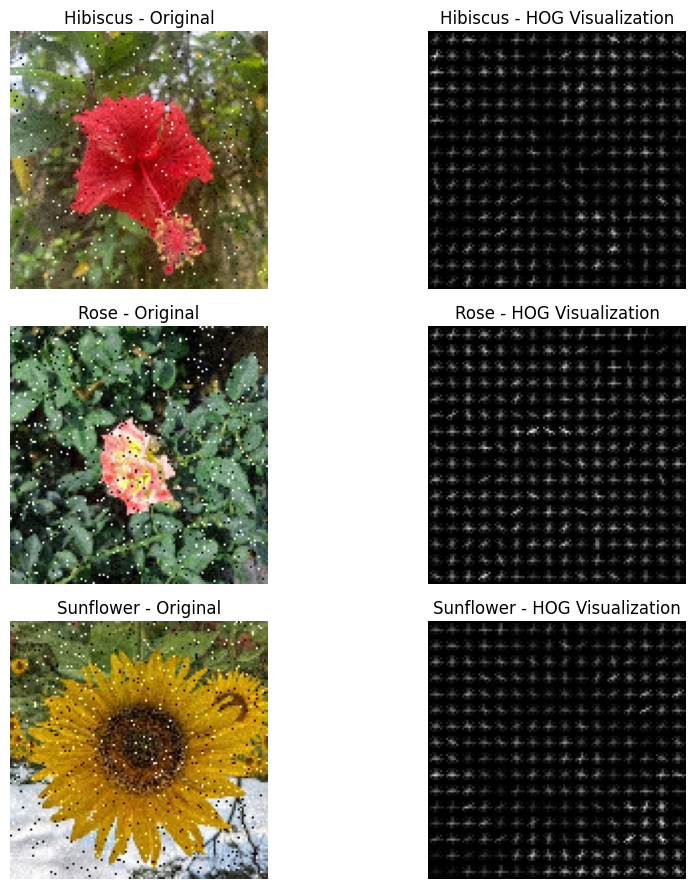

In [9]:
# Create a figure with dynamic height based on number of classes
plt.figure(figsize=(10, len(class_names) * 3))

# Loop through each flower class
for i, class_name in enumerate(class_names):

    # Select the first image index belonging to the current class
    idx = np.where(labels == i)[0][0]

    # ---------------- Original Image ----------------
    plt.subplot(len(class_names), 2, i*2 + 1)

    # Convert BGR (OpenCV) to RGB for correct visualization
    plt.imshow(cv2.cvtColor(images[idx], cv2.COLOR_BGR2RGB))
    plt.title(f"{class_name} - Original")
    plt.axis("off")

    # ---------------- HOG Visualization ----------------
    hog_img = hog_images[idx]

    # Normalize HOG image for better contrast
    hog_img = (hog_img - hog_img.min()) / (hog_img.max() - hog_img.min())

    plt.subplot(len(class_names), 2, i*2 + 2)
    plt.imshow(hog_img, cmap="gray")
    plt.title(f"{class_name} - HOG Visualization")
    plt.axis("off")

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


## **Color Features**

In [13]:
# Number of bins for histograms
bins = 32

color_features = []

for img in images:
    rgb_hist = []
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    for i in range(3):
        # RGB histogram
        rgb_hist.extend(cv2.calcHist([img], [i], None, [bins], [0, 256]).flatten())
        # HSV histogram
        rgb_hist.extend(cv2.calcHist([hsv], [i], None, [bins], [0, 256]).flatten())

    color_features.append(rgb_hist)

color_features = np.array(color_features)
print("Color features shape:", color_features.shape)


Color features shape: (468, 192)


### **Color Features Visualization**

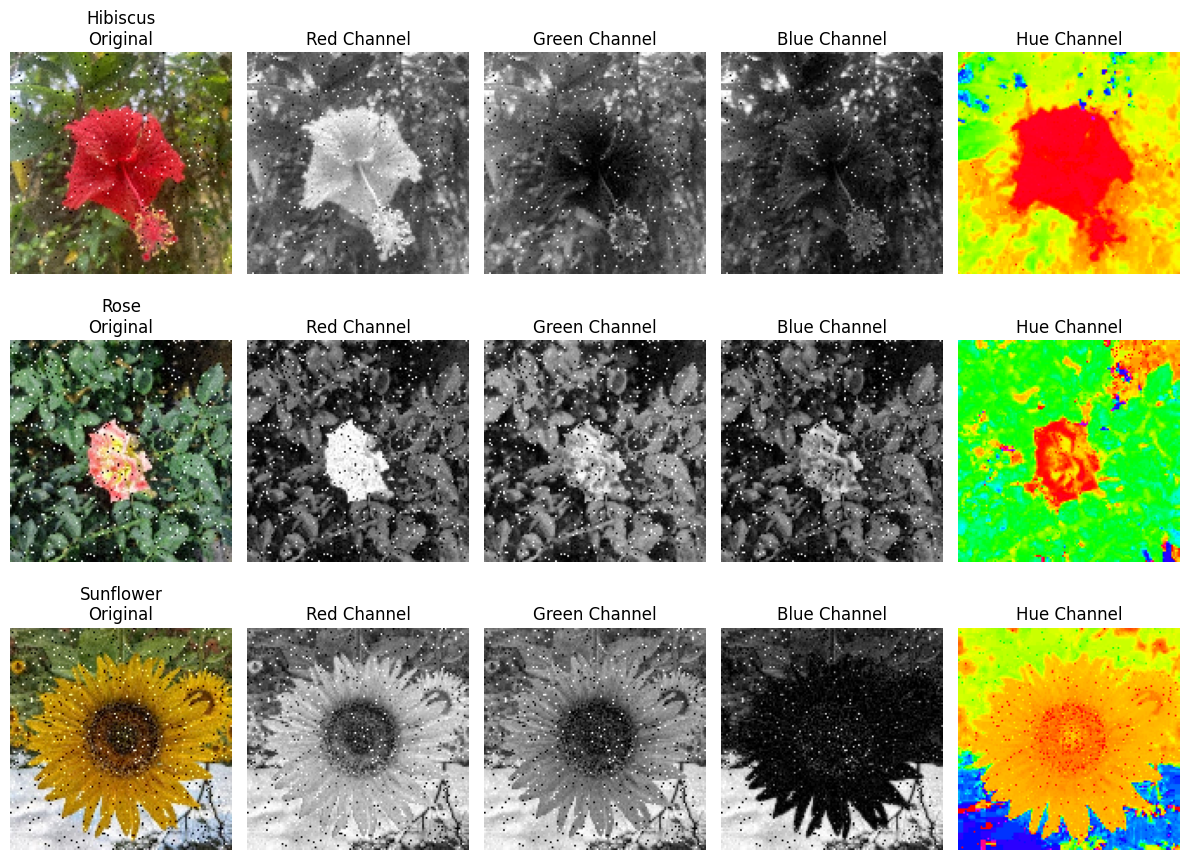

In [16]:
plt.figure(figsize=(12, len(class_names) * 3))

for i, class_name in enumerate(class_names):
    idx = np.where(labels == i)[0][0]
    img = images[idx]
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    # -------- Original Image --------
    plt.subplot(len(class_names), 5, i*5 + 1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(f"{class_name}\nOriginal")
    plt.axis("off")

    # -------- Red Channel --------
    plt.subplot(len(class_names), 5, i*5 + 2)
    plt.imshow(img[:, :, 2], cmap="gray")
    plt.title("Red Channel")
    plt.axis("off")

    # -------- Green Channel --------
    plt.subplot(len(class_names), 5, i*5 + 3)
    plt.imshow(img[:, :, 1], cmap="gray")
    plt.title("Green Channel")
    plt.axis("off")

    # -------- Blue Channel --------
    plt.subplot(len(class_names), 5, i*5 + 4)
    plt.imshow(img[:, :, 0], cmap="gray")
    plt.title("Blue Channel")
    plt.axis("off")

    # -------- Hue Channel (HSV) --------
    plt.subplot(len(class_names), 5, i*5 + 5)
    plt.imshow(hsv[:, :, 0], cmap="hsv")
    plt.title("Hue Channel")
    plt.axis("off")

plt.tight_layout()
plt.show()


**Combine Features**

In [17]:
# Combine HOG features (shape & texture information)
# with color features (color distribution information)
# Feature fusion is done by horizontally stacking both feature vectors
X_features = np.hstack((hog_features, color_features))

# Print the final feature matrix shape
# Rows   -> number of images
# Columns-> total combined features (HOG + Color)
print(X_features.shape)


(468, 8292)


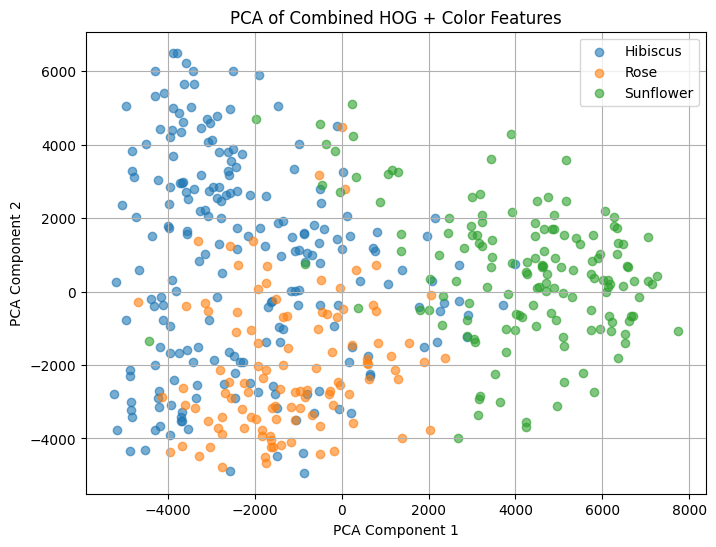

In [18]:
# ---------------- PCA for Dimensionality Reduction ----------------
# We use PCA to reduce the high-dimensional combined feature vectors
# (HOG + color histograms) to 2 dimensions for visualization
from sklearn.decomposition import PCA

# Initialize PCA to 2 components for 2D plotting
pca = PCA(n_components=2)

# Fit PCA on combined features and transform them
X_pca = pca.fit_transform(X_features)

# ---------------- Scatter Plot of PCA Components ----------------
plt.figure(figsize=(8,6))

# Plot each flower class in the PCA space
for i, class_name in enumerate(class_names):
    plt.scatter(
        X_pca[labels == i, 0],  # PCA component 1
        X_pca[labels == i, 1],  # PCA component 2
        label=class_name,       # Class label for legend
        alpha=0.6               # Transparency for better visibility
    )

# Label axes and title
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("PCA of Combined HOG + Color Features")

# Add legend for classes
plt.legend()

# Add grid for readability
plt.grid(True)

# Show the plot
plt.show()


# **Train-Test Split + Scalling of Extracted Features**

In [19]:
# ---------------- Train-Test Split ----------------
# Split the combined feature dataset into training and testing sets
# - X_features : combined HOG + color features
# - labels     : corresponding class labels
# - test_size=0.2 : 20% of data is reserved for testing
# - stratify=labels : ensures each class is proportionally represented in train and test
# - random_state=42 : ensures reproducibility
X_train, X_test, y_train, y_test = train_test_split(
    X_features, labels, test_size=0.2, stratify=labels, random_state=42
)

# ---------------- Feature Scaling ----------------
# Standardize features by removing the mean and scaling to unit variance
# This is important for algorithms like SVM to perform well
scaler = StandardScaler()

# Fit the scaler on training data and transform training set
X_train = scaler.fit_transform(X_train)

# Transform the test set using the same scaler (do not fit again!)
X_test = scaler.transform(X_test)


# **Models**

## **Random Forest Model**

In [20]:
# ---------------- Random Forest Classifier ----------------
# Initialize Random Forest with 200 trees and fixed random seed for reproducibility
rf_model = RandomForestClassifier(n_estimators=200, random_state=42)

# Train the model on the training data
rf_model.fit(X_train, y_train)

# Predict labels for the test set
rf_preds = rf_model.predict(X_test)

# Evaluate performance: accuracy and detailed classification report
print("Random Forest Accuracy:", accuracy_score(y_test, rf_preds))
print("\n", classification_report(y_test, rf_preds))


Random Forest Accuracy: 0.9361702127659575

               precision    recall  f1-score   support

           0       0.91      0.95      0.93        43
           1       0.95      0.95      0.95        22
           2       0.96      0.90      0.93        29

    accuracy                           0.94        94
   macro avg       0.94      0.93      0.94        94
weighted avg       0.94      0.94      0.94        94



**SVM Model**

In [21]:
# ---------------- Support Vector Machine (SVM) ----------------
# Initialize SVM with RBF kernel, regularization C=10, and gamma='scale'
svm_model = SVC(kernel='rbf',
                C=10,
                gamma='scale')

# Train the SVM on the training data
svm_model.fit(X_train, y_train)

# Predict labels for the test set
svm_preds = svm_model.predict(X_test)

# Evaluate performance: accuracy and detailed classification report
print("SVM Accuracy:", accuracy_score(y_test, svm_preds))
print("\n", classification_report(y_test, svm_preds))


SVM Accuracy: 0.9042553191489362

               precision    recall  f1-score   support

           0       0.83      1.00      0.91        43
           1       1.00      0.77      0.87        22
           2       1.00      0.86      0.93        29

    accuracy                           0.90        94
   macro avg       0.94      0.88      0.90        94
weighted avg       0.92      0.90      0.90        94



**CNN Model**

***Initial CNN Model***

*The initial CNN was trained from scratch on a small image dataset. Since CNNs require large amounts of data to learn effective visual features, the limited dataset led to poor generalization and higher misclassification, especially between visually similar classes. Consequently, the CNN underperformed compared to traditional models such as Random Forest and Support Vector Machine, which are better suited for smaller datasets.*

In [22]:
# ------------------- Prepare Image Data -------------------
# Normalize pixel values to range [0,1] for better CNN performance
X_img = images / 255.0

# Split images and labels into training and testing sets (80-20), keeping class proportions
X_train_img, X_test_img, y_train_img, y_test_img = train_test_split(
    X_img, labels, test_size=0.2, stratify=labels, random_state=42
)

# ------------------- Define CNN Model -------------------
cnn_model = Sequential([
    # 1st Convolution + MaxPooling
    Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    MaxPooling2D(2,2),

    # 2nd Convolution + MaxPooling
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    # 3rd Convolution + MaxPooling
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    # Flatten feature maps and connect to Dense layers
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),  # Prevent overfitting
    Dense(len(class_names), activation='softmax')  # Output layer for classification
])

# ------------------- Compile CNN -------------------
# Use Adam optimizer and sparse categorical crossentropy for multi-class classification
cnn_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# ------------------- Train CNN -------------------
cnn_model.fit(
    X_train_img,
    y_train_img,
    epochs=15,
    batch_size=32,
    validation_split=0.1  # Use 10% of training data for validation
)

# ------------------- Evaluate CNN -------------------
cnn_loss, cnn_acc = cnn_model.evaluate(X_test_img, y_test_img)
print("CNN Accuracy:", cnn_acc)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 16s 997ms/step - accuracy: 0.4392 - loss: 1.1553 - val_accuracy: 0.6842 - val_loss: 0.6848
Epoch 2/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - accuracy: 0.7383 - loss: 0.6012 - val_accuracy: 0.6316 - val_loss: 0.5103
Epoch 3/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8088 - loss: 0.4585 - val_accuracy: 0.8158 - val_loss: 0.3921
Epoch 4/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.8607 - loss: 0.3504 - val_accuracy: 0.8158 - val_loss: 0.3332
Epoch 5/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9204 - loss: 0.2533 - val_accuracy: 0.8947 - val_loss: 0.2873
Epoch 6/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8837 - loss: 0.2724 - val_accuracy: 0.8158 - val_loss: 0.3656
Epoch 7/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9216 - loss: 0.2137 - val_accuracy: 0.8158 - val_loss: 0.3569
Epoch 8/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8874 - loss: 0.2083 - val_accuracy: 0.8158 -

***Final Improved CNN Model***

*To overcome the limitations of the initial CNN, transfer learning was implemented using the MobileNetV2 model pretrained on ImageNet. The pretrained network provided robust feature representations, removing the need to learn basic visual patterns from scratch. Data augmentation techniques, including rotation, zooming, shifting, and horizontal flipping, were applied to increase training data diversity and reduce overfitting. As a result, the improved CNN achieved better feature extraction, higher classification accuracy, and improved generalization, with reduced class confusion on unseen test data, demonstrating the effectiveness of pretrained models for small-scale image classification.*

In [23]:
# ------------------- Normalize Images -------------------
# Convert images to float32 and scale pixel values to [0,1] for CNN training
X_img = images.astype("float32") / 255.0

# ------------------- Train-Test Split -------------------
# Split dataset into training (80%) and testing (20%) sets
# stratify=labels ensures proportional representation of all classes
X_train_img, X_test_img, y_train_img, y_test_img = train_test_split(
    X_img,
    labels,
    test_size=0.2,
    stratify=labels,
    random_state=42
)

# ------------------- Data Augmentation -------------------
# Apply random transformations to training images to improve generalization
datagen = ImageDataGenerator(
    rotation_range=25,       # rotate images randomly by ±25 degrees
    width_shift_range=0.1,   # shift images horizontally
    height_shift_range=0.1,  # shift images vertically
    zoom_range=0.2,          # random zoom
    horizontal_flip=True      # random horizontal flip
)
datagen.fit(X_train_img)

# ------------------- Transfer Learning Base Model -------------------
# Use MobileNetV2 pretrained on ImageNet as feature extractor
base_model = MobileNetV2(
    weights="imagenet",
    include_top=False,           # exclude default classification head
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)
base_model.trainable = False    # Freeze pretrained layers to retain learned features

# ------------------- Final CNN Model -------------------
# Add custom classification head on top of base model
cnn_model = Sequential([
    base_model,                  # pretrained feature extractor
    GlobalAveragePooling2D(),    # convert feature maps to 1D

    Dense(128, activation="relu"), # fully connected layer
    Dropout(0.5),                  # prevent overfitting

    Dense(len(class_names), activation="softmax") # output layer for multi-class classification
])

# ------------------- Compile Model -------------------
cnn_model.compile(
    optimizer=Adam(learning_rate=1e-4),   # Adam optimizer with small LR
    loss="sparse_categorical_crossentropy", # suitable for integer labels
    metrics=["accuracy"]
)

# ------------------- Train Model -------------------
# Train using augmented data generator for better generalization
history = cnn_model.fit(
    datagen.flow(X_train_img, y_train_img, batch_size=32),
    epochs=30,
    validation_data=(X_test_img, y_test_img)
)

# ------------------- Evaluate Model -------------------
cnn_loss, cnn_acc = cnn_model.evaluate(X_test_img, y_test_img)
print("Improved CNN Accuracy:", cnn_acc)

# ------------------- Predict Class Labels -------------------
cnn_probs = cnn_model.predict(X_test_img)
cnn_preds = np.argmax(cnn_probs, axis=1)

# ------------------- Classification Report -------------------
# Shows precision, recall, f1-score for each flower class
print("\nCNN Classification Report:")
print(classification_report(y_test_img, cnn_preds))


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 44s 3s/step - accuracy: 0.3624 - loss: 1.7498 - val_accuracy: 0.5638 - val_loss: 0.9304
Epoch 2/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 0.5464 - loss: 1.0252 - val_accuracy: 0.7660 - val_loss: 0.6301
Epoch 3/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - accuracy: 0.7091 - loss: 0.7311 - val_accuracy: 0.8617 - val_loss: 0.4485
Epoch 4/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 220ms/step - accuracy: 0.7551 - loss: 0.6469 - val_accuracy: 0.8936 - val_loss: 0.3547
Epoch 5/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 150ms/step - accuracy: 0.7506 - loss: 0.4957 - val_accuracy: 0.9149 - val_loss: 0.2879
Epoch 6/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 0.8296 - loss: 0.4284 - val_accuracy: 0.9468 - val_loss: 0.2335
Epoch 7/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 0.9003 - loss: 0.3277 - val_accuracy: 0.9468 - val_loss: 0.1993
Epoch 8/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 0.8935 - loss: 0.2939 - val_accuracy: 0.94

***CNN plot training accuracy and loss***

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


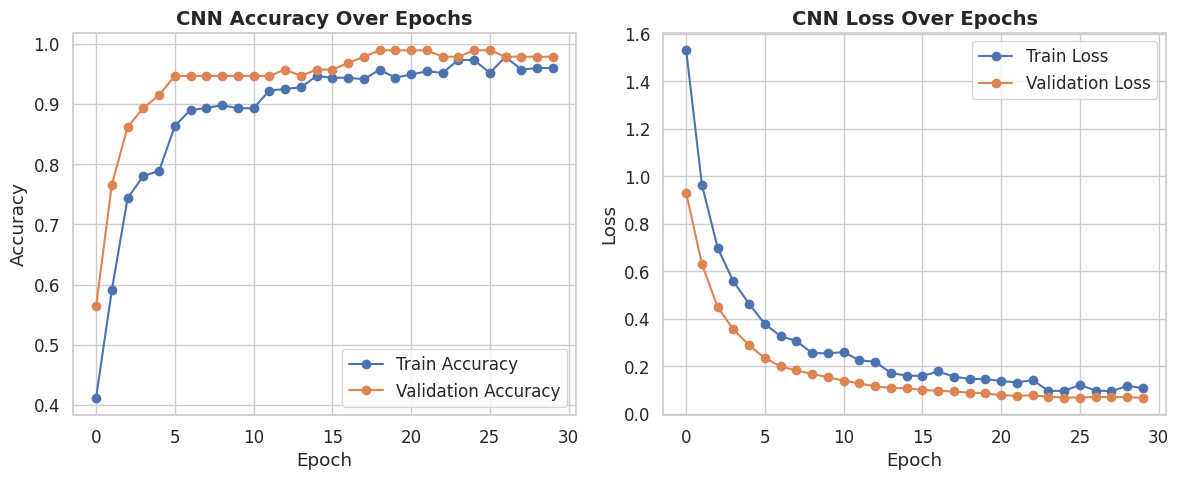

In [26]:
# ------------------- CNN Predictions -------------------
# Predict class probabilities for the test set and take the class with highest probability
cnn_preds = np.argmax(cnn_model.predict(X_test_img), axis=1)

# ------------------- Plot Training Accuracy and Loss -------------------
plt.figure(figsize=(12,5))

# ----- Accuracy Plot -----
plt.subplot(1,2,1)
# Plot training and validation accuracy over epochs
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('CNN Accuracy Over Epochs', fontsize=14, weight='bold')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# ----- Loss Plot -----
plt.subplot(1,2,2)
# Plot training and validation loss over epochs
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('CNN Loss Over Epochs', fontsize=14, weight='bold')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()


# **Confusion Matrix (All Models)**

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


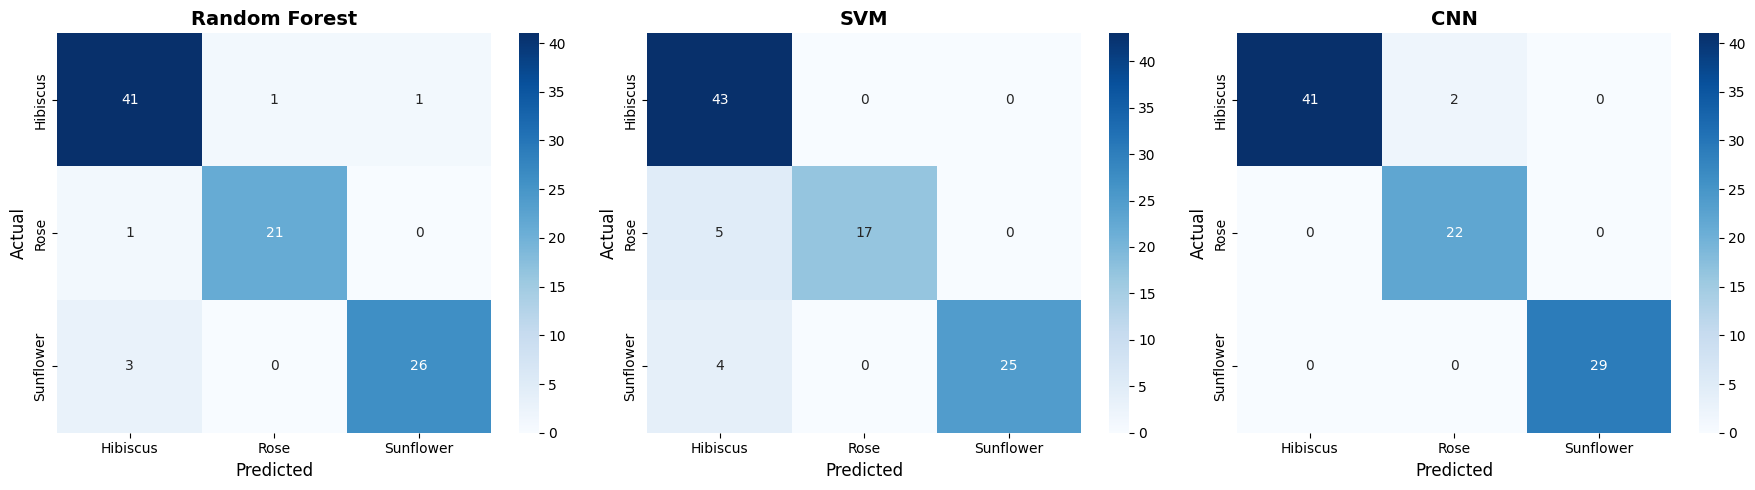

In [24]:
import seaborn as sns

# ------------------- Function to Plot Confusion Matrix -------------------
def plot_cm(y_true, y_pred, title, class_names):
    """
    Plot a confusion matrix with class labels.
    - y_true: actual labels
    - y_pred: predicted labels
    - title: title of the plot
    - class_names: list of class names for axes
    """
    cm = confusion_matrix(y_true, y_pred)  # Compute confusion matrix
    sns.heatmap(
        cm,
        annot=True,             # Show numbers in cells
        fmt='d',                # Format as integers
        cmap='Blues',           # Color map
        xticklabels=class_names, # X-axis labels
        yticklabels=class_names  # Y-axis labels
    )
    plt.title(title, fontsize=14, weight='bold')
    plt.xlabel("Predicted", fontsize=12)
    plt.ylabel("Actual", fontsize=12)

# ------------------- Plot Confusion Matrices Side by Side -------------------
plt.figure(figsize=(18,5))

# Random Forest
plt.subplot(1, 3, 1)
plot_cm(y_test, rf_preds, "Random Forest", class_names)

# SVM
plt.subplot(1, 3, 2)
plot_cm(y_test, svm_preds, "SVM", class_names)

# CNN
cnn_preds = np.argmax(cnn_model.predict(X_test_img), axis=1)
plt.subplot(1, 3, 3)
plot_cm(y_test_img, cnn_preds, "CNN", class_names)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

# **Final Comparision**

In [31]:
# Function to calculate metrics for a model
def get_model_metrics(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred) * 100
    report = classification_report(y_true, y_pred, output_dict=True)

    # Average precision, recall, f1-score across all classes
    precision = np.mean([report[label]['precision'] for label in report if label not in ('accuracy','macro avg','weighted avg')]) * 100
    recall = np.mean([report[label]['recall'] for label in report if label not in ('accuracy','macro avg','weighted avg')]) * 100
    f1 = np.mean([report[label]['f1-score'] for label in report if label not in ('accuracy','macro avg','weighted avg')]) * 100

    return acc, precision, recall, f1

# Get metrics for all models
rf_metrics = get_model_metrics(y_test, rf_preds)
svm_metrics = get_model_metrics(y_test, svm_preds)
cnn_metrics = get_model_metrics(y_test_img, cnn_preds)

# Print table header
print(f"{'Model':<15} {'Accuracy (%)':<12} {'Precision (%)':<14} {'Recall (%)':<12} {'F1-Score (%)':<14}")
print("-"*70)

# Print rows
print(f"{'Random Forest':<15} {rf_metrics[0]:<12.2f} {rf_metrics[1]:<14.2f} {rf_metrics[2]:<12.2f} {rf_metrics[3]:<14.2f}")
print(f"{'SVM':<15} {svm_metrics[0]:<12.2f} {svm_metrics[1]:<14.2f} {svm_metrics[2]:<12.2f} {svm_metrics[3]:<14.2f}")
print(f"{'CNN':<15} {cnn_metrics[0]:<12.2f} {cnn_metrics[1]:<14.2f} {cnn_metrics[2]:<12.2f} {cnn_metrics[3]:<14.2f}")

Model           Accuracy (%) Precision (%)  Recall (%)   F1-Score (%)  
----------------------------------------------------------------------
Random Forest   93.62        94.29          93.49        93.83         
SVM             90.43        94.23          87.83        90.10         
CNN             97.87        97.22          98.45        97.76         


/tmp/ipython-input-3594993884.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


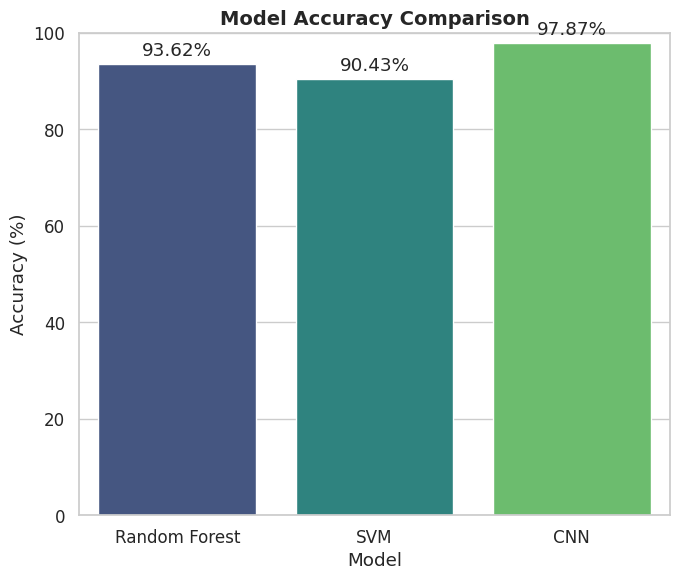

In [25]:
# ------------------- Compile Model Accuracy Results -------------------
results = {
    "Model": ["Random Forest", "SVM", "CNN"],      # Model names
    "Accuracy": [
        accuracy_score(y_test, rf_preds),         # Random Forest accuracy
        accuracy_score(y_test, svm_preds),        # SVM accuracy
        cnn_acc                                   # CNN accuracy
    ]
}

import pandas as pd

# Create a DataFrame for easier plotting and display
results_df = pd.DataFrame(results)
results_df["Accuracy (%)"] = results_df["Accuracy"] * 100  # Convert to percentage

# ------------------- Set Seaborn Style -------------------
sns.set_theme(style="whitegrid", font_scale=1.1)

# ------------------- Plot Accuracy Comparison -------------------
plt.figure(figsize=(7,6))
ax = sns.barplot(
    data=results_df,
    x="Model",
    y="Accuracy (%)",
    palette="viridis"  # Color palette
)

# Axis and title settings
plt.ylim(0, 100)
plt.title("Model Accuracy Comparison", fontsize=14, weight="bold")
plt.xlabel("Model")
plt.ylabel("Accuracy (%)")

# Add value labels on top of each bar
for container in ax.containers:
    ax.bar_label(container, fmt="%.2f%%", padding=3)

# Adjust layout
plt.tight_layout()
plt.show()
